In [2]:
from collections import defaultdict

index_cols = defaultdict(int)
index_cols.update({
    "r-gitto-rank":1,
    'r-gitto-sirank':1,
    'r-heartsvg': 1,
    'somde':3,
    'spatialde':3,
})

p_use_columns = {
    "geary":"pval_norm_fdr_bh",
    "moran":"pval_norm_fdr_bh",
    "r-gitto-rank":"adj.p.value",
    "r-sparkx":"adjustedPval",
    'somde':'qval',
    'spatialde':'qval',
    'spanve-d':'fdrs',
    'spanve-k':'fdrs',
    'r-heartsvg': 'p_adj',
    'r-meringue': 'p.adj',
    'r-spagene': 'adjp',
    'scgco': 'fdr',
    # 'p.spanve-d':'fdrs',
    # 'p.spanve-k':'fdrs'
}

score_use_columns = {
    'r-gitto-sirank':'scores',
    'sepal':'average',
    'cell_ranger':'dispersions_norm'
}

import os
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as chscore
from sklearn.metrics import davies_bouldin_score as dbscore
from sklearn.metrics import silhouette_score as siscore
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests

result_dir = "./recode/Simulation2/"
data_ids = os.listdir(result_dir)
softs = [
    'spanve-k','spanve-d',
    'somde', 'cell_ranger',
    'moran','geary',
    'r-sparkx','r-gitto-rank','sepal',
    'r-gitto-sirank','spatialde',#'p.spanve-k','p.spanve-d',
    'r-heartsvg', 'r-meringue', 'r-spagene', 'scgco'
]

def parse_file(data_dir,soft):
    path = os.path.join(result_dir,data_dir,soft)
    try:
        file = [i for i in os.listdir(path) if i.endswith('csv')][0]
    except:
        print(data_dir,soft,'have no result file.')
        return None
    file = os.path.join(path,file)
    if soft not in p_use_columns:
        use_col = score_use_columns[soft]
    elif soft in p_use_columns:
        use_col = p_use_columns[soft]
    else: print(soft)
    
    df = pd.read_csv(file,index_col=index_cols[soft])
    if soft in ['moran','geary']:
        _0, fdrs, _1, _2, = multipletests(df['pval_norm'].fillna(1), method='fdr_bh')
        df[use_col] = fdrs
    df = df[use_col]
    df.index.name = 'genes'
    df = df.reset_index().groupby(by='genes').mean().iloc[:,0]
    df.name = soft
    return df

In [3]:
def cal_sensitivity(true, pred):
    return (pred & true).sum()/ true.sum()
def cal_specification(true, pred):
    return ((~pred) & (~true)).sum()/ (~true).sum()

def get_recoder(metrics_func):
    recoder = pd.DataFrame(columns = ['data','soft','random_noise_level','drop_out','score'])

    for data_id in data_ids:
        df_datares = pd.concat(
            [parse_file(data_id,soft) for soft in softs],
            axis=1
        )
        
        for ps in p_use_columns:
            df_datares[ps] = df_datares[ps].fillna(1)
        for ss in score_use_columns:
            if ss == 'sepal':df_datares[ps] = df_datares[ps].fillna(1);continue
            df_datares[ps] = df_datares[ps].fillna(0)
    
        df_datares['sepal'] = 1-df_datares['sepal']

        data_id = data_id[0:-5]
        rn = float(data_id.split('_')[1])
        do = float(data_id.split('_')[2])

        for soft in df_datares.columns:

            if soft in p_use_columns:
                pred = df_datares[soft]<0.05
            elif soft in score_use_columns:
                n_select = int(df_datares.shape[0] * 0.5)
                thres = df_datares[soft].sort_values(ascending=False)[n_select]
                pred = df_datares[soft]>thres
                
            score = metrics_func(pd.Series([1]*50+[0]*50, dtype = bool, index = [f'gene_{i}' for i in range(100)]), pred)
            recoder.loc[len(recoder),:] = data_id,soft,rn,do,score
    
    recoder['soft'] = recoder['soft'].map({
        'spanve-k':'Spanve-k',
        'spanve-d':'Spanve-d',
        'somde':'SOMDE',
        'moran':'Moran test',
        'geary':'Geary test',
        'r-sparkx':'SPARK-X',
        'r-gitto-rank':'Gitto-Rank',
        'sepal':'sepal*',
        'r-gitto-sirank':'Gitto-siRank*',
        'spatialde':'SpatialDE',
        'r-meringue':"MERIINGUE",
        'cell_ranger': 'HVG*',
        'r-heartsvg': 'heartSVG',  
        'r-spagene': 'SpaGene', 
        'scgco': 'scGCO'
        }
    )
    return recoder

In [4]:
recoder_s1 = get_recoder(cal_sensitivity)
recoder_s2 = get_recoder(cal_specification)

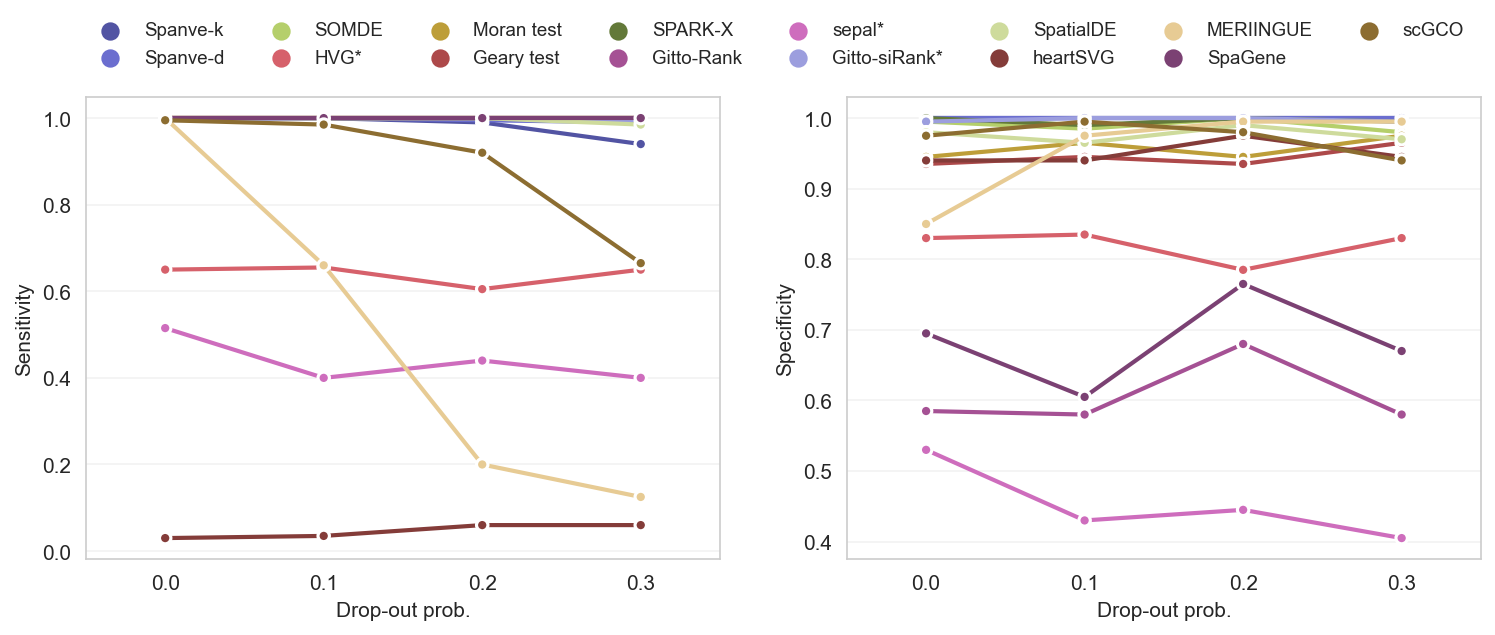

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style='whitegrid')
sns.set_style(style={'grid.color': '.95',})

color_map ='tab20b_r' #sns.diverging_palette(220,10,n=12,l=50,s=65)
color_map = {
    s:sns.color_palette('tab20b_r', n_colors = 15)[i] for i, s in enumerate(recoder_s2.groupby('soft')['score'].mean().sort_values().index)
}

f,axes = plt.subplots(1,2,dpi=150,figsize=(12,4))

g0 = sns.pointplot(
    data=recoder_s1, x="drop_out", y="score", hue="soft",
    palette=color_map,
    ax = axes[0],
    errorbar=('ci', False),
    # hue_order=order
)
g0.legend_.set_visible(False)
g0.set(xlabel="Drop-out prob.")
g0.set(ylabel="Sensitivity")

for i in range(len(g0.lines)):
    g0.lines[i].set_linewidth(2)
for i in g0.collections:
    i.set_sizes([30 for _ in range(9)])
    i.set_edgecolor('white')
    i.set_lw(1.5)

g1 = sns.pointplot(
    data=recoder_s2, x="drop_out", y="score", hue="soft",
    palette=color_map,
    ax = axes[1],
    errorbar=('ci', False),
    # hue_order=order,
)
g1.legend(bbox_to_anchor=[1,1.2],edgecolor='white',ncol=8, fontsize=9)

for i in range(len(g1.lines)):
    g1.lines[i].set_linewidth(2)
for i in g1.collections:
    i.set_sizes([30 for _ in range(9)])
    i.set_edgecolor('white')
    i.set_lw(1.5)
g1.set(xlabel="Drop-out prob.")
g1.set(ylabel="Specificity")
f.savefig('./figures/Sim_Noise.pdf', bbox_inches='tight')

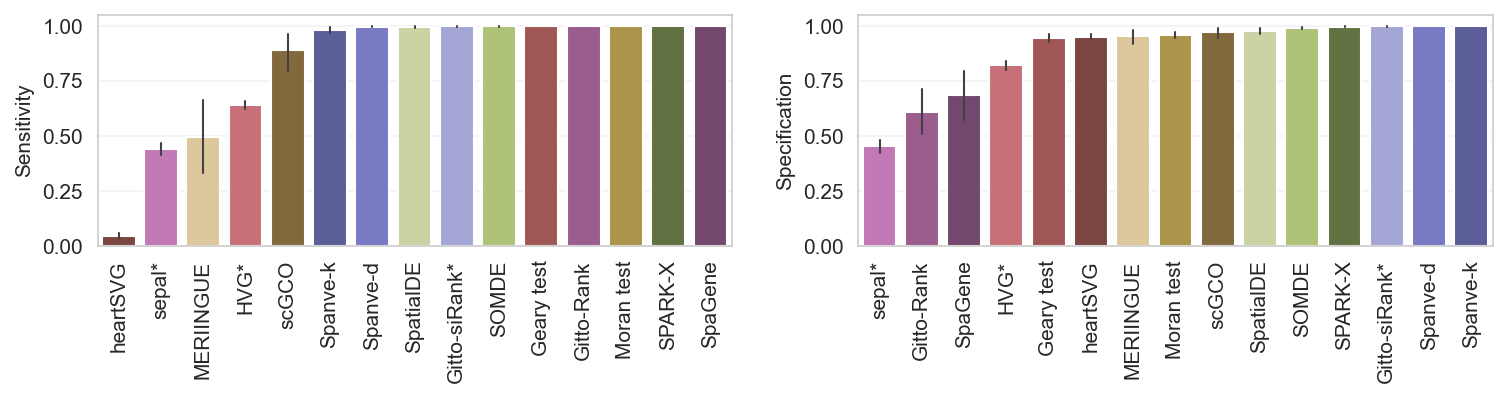

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns


f,axes = plt.subplots(1,2,dpi=150,figsize=(12,2))
ax = sns.barplot(
    data = recoder_s1,
    x='soft',y='score',
    order = recoder_s1.groupby('soft')['score'].mean().sort_values().index,
    capsize=0,errwidth=1,
    palette = color_map,
    ax=axes[0]
)
# ax.set_ylim(0.6,1.05)
# ax.set_xticklabels([])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Sensitivity')

ax = sns.barplot(
    data = recoder_s2,
    x='soft',y='score',
    order = recoder_s2.groupby('soft')['score'].mean().sort_values().index,
    capsize=0,errwidth=1,
    palette = color_map,
    ax=axes[1]
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Specification')
ax.set_xlabel('')

f.savefig('./figures/Sim_spe&sen.pdf', bbox_inches='tight')